I will collect a whole sequence of model runs in this notebook to have a better structure for the plots going into the presentation. I still think in the end it will be nicer to put all of this into a proper Python code package.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from jax import random
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS

import scipy
import numpy as np
import random as rnd
from numpyro.infer import Predictive

plt.style.use("https://raw.githubusercontent.com/simon-ast/matplotlib-plot-style/main/corner_style.mplstyle")

In [2]:
initial_data = pd.read_csv("M5_RGB.csv")
new_data = initial_data.loc[(initial_data["dCUBI"] > -0.5) & (initial_data["dCUBI"] < 1.5)]

data = jnp.array(new_data["dCUBI"])
data_err = jnp.array(new_data["e_CUBI"])

In [3]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.funsor import config_enumerate

In [4]:
# A quick helper function to disentangle the posterior samples
import corner

def process_posterior_samples(samples, n_comp):
    # Structure of these is (potentially multi-d) arrays
    posterior_dict = {}
    model_parameters = {f"comp_{nbr + 1}": {} for nbr in range(n_comp)}

    for key, sample_arr in samples.items():
        # Strip all decorators from key string
        clean_key = key.replace(".", "").lower()

        # Find multi-d arrays
        try: 
            num_pars = sample_arr.shape[1]
            for index in range(num_pars):
                chain = sample_arr[:, index]
                posterior_dict[f"{clean_key}_{index + 1}"] = chain
                model_parameters[f"comp_{index + 1}"][f"{clean_key}_med"] = corner.quantile(chain, q=0.5)
            
        except IndexError:
            chain = sample_arr
            posterior_dict[f"{clean_key}_0"] = chain
            
            for idx in range(n_comp):
                model_parameters[f"comp_{idx + 1}"][f"{clean_key}_med"] = corner.quantile(chain, q=0.5)  

    return posterior_dict, model_parameters


def disentangle_chains(grouped_posteriors, n_comp):
    keys = list(grouped_posteriors.keys())
    num_chains = grouped_posteriors[keys[0]].shape[0]
    
    final_dict = {}
    for chain_idx in range(num_chains):
        final_dict[f"chain_{chain_idx + 1}"] = {}
        
        for key in keys:
            final_dict[f"chain_{chain_idx + 1}"][key] = grouped_posteriors[key][chain_idx, :, :]
    
    best_dict = {}
    for chain, samples in final_dict.items():
        best_dict[chain] = process_posterior_samples(samples, n_comp)[0]

    return best_dict

In [13]:
def plot_twocomp_comparison(data_array, label, mu1, scale1, weight1, mu2, scale2, weight2, fraction=1.):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Histogramme of data
    ax.hist(data_array, bins=40, density=True, color="k", alpha=.3)
    ax.set(xlabel=label, ylabel="Density")
    ylims = ax.get_ylim()
    
    # Overplotting the mixture components
    x_array = jnp.arange(jnp.min(data_array), jnp.max(data_array), 0.01)
    
    # Decide how many "lines" to plot
    draws = int(mu1.shape[0] * fraction)
    
    for idx in np.array(rnd.sample(range(0, mu1.shape[0]), draws)):
        y_array_1 = weight1[idx] * scipy.stats.norm.pdf(
                x_array, loc=mu1[idx], scale=scale1[idx]
        )
        y_array_2 = weight2[idx] * scipy.stats.norm.pdf(
                x_array, loc=mu2[idx], scale=scale2[idx]
        )
        
        ax.plot(x_array, y_array_1, c="tab:red", alpha=0.003)
        ax.plot(x_array, y_array_2, c="tab:blue", alpha=0.003)
    
    # Finally, we overplot the "median" solution (50% quantile)
    ax = plot_mixture_component(x_array, ax, "P1", "darkred", mu1, scale1, weight1)
    ax = plot_mixture_component(x_array, ax, "P2", "darkblue", mu2, scale2, weight2)
    
    # Restrict to histogramme y-lims
    ax.set(ylim=ylims)
    ax.legend(loc="upper left")


def plot_mixture_component(x_array, axis, label, colour, mu, scale, weight):
    mu_low, mu_med, mu_high = np.percentile(mu, [0.15, 50, 99.85])
    scale_low, scale_med, scale_high = np.percentile(scale, [0.15, 50, 99.85])
    weight_low, weight_med, weight_high = np.percentile(weight, [0.15, 50, 99.85])
    
    y_array_med = weight_med * scipy.stats.norm.pdf(
        x_array, loc=mu_med, scale=scale_med
    )
    
    #labelstr = (
    #    f"{label_string("$\\mu$", mu_med, mu_low, mu_high)}\n"
    #    f"{label_string("$\\sigma$", scale_med, scale_low, scale_high)}\n"
    #    f"{label_string("$\\omega$", weight_med, weight_low, weight_high)}\n"
    #)
    axis.plot(x_array, y_array_med, lw=2.5, c=colour, ls="--",
              label=label)
           #label=f"{label}\n{labelstr}")
    
    return axis


def label_string(sign, med, lo, high):
    lower_bound = f"-{med-lo:.2f}"
    upper_bound = f"+{high-med:.2f}"
    full_string = f"{sign} = ${med:.2f}^{{{upper_bound}}}_{{{lower_bound}}}$"
    
    return full_string

In [6]:
# A small helper function to plot all chains in one corner plot
def corner_chains(chain_dict, figure=None, selection=None):
    
    num_chains = len(list(chain_dict.keys()))
    c_idx = 0
    colors = plt.cm.jet(np.linspace(0, 1, num_chains))
    
    for chain, samples in chain_dict.items():
        
        if selection is not None:
            samples = {
                name: samples[name]
                for name in selection
            }
        
        figure = corner.corner(samples, color=colors[c_idx], fig=figure)
        c_idx += 1
    
    return None

In [7]:
@config_enumerate
def model_univariate_ordered(
    data: jnp.array,
    data_err,
    num_comp: int,
    loc_priors: tuple,
    scale_priors: float,
):
    """
    Numpyro model of single-variate, multi-component Normal distribution.
    """
    # Initialise weights based on number of components
    weights = numpyro.sample("weight", dist.Dirichlet(
        0.5 * jnp.ones(num_comp))
    )

    # Unpack the priors
    loc_mu, loc_scale = loc_priors
    scale_scale = scale_priors
        
    # Define second mode relative
    loc1 = numpyro.sample("loc", dist.Normal(loc_mu, loc_scale))
    distance = numpyro.sample("gap", dist.HalfNormal(3.0))
    loc2 = loc1 + distance
    
    with numpyro.plate("Component", num_comp):
        scale = numpyro.sample("scale", dist.HalfNormal(scale_scale))
    
    # Make combined arrays
    loc = jnp.array([loc1, loc2])

    with numpyro.plate("Data", len(data)):
        # Local variables        
        assignment = numpyro.sample("Assignment", dist.Categorical(weights))
        
        numpyro.sample(
            "Obs.", dist.Normal(loc[assignment], jnp.sqrt(scale[assignment] ** 2 + data_err ** 2)),
            obs=data
        )

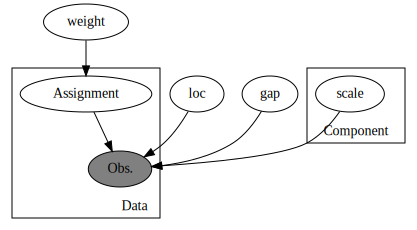

In [8]:
num_comp = 2
numpyro.render_model(
    model_univariate_ordered, 
    model_args=(data, data_err, num_comp, (0.5, 3.0), 3.0)
)

In [9]:
kernel_order = NUTS(model_univariate_ordered)
mcmc_order = MCMC(kernel_order, num_warmup=1000, num_samples=5000, num_chains=5)
num_comp = 2
mcmc_order.run(random.key(2), data, data_err, num_comp, (0.5, 3.0), 3.0)

/tmp/ipykernel_7571/2021903504.py:2: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_order = MCMC(kernel_order, num_warmup=1000, num_samples=5000, num_chains=5)
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:16<00:00, 367.40it/s, 15 steps of size 2.02e-01. acc. prob=0.94]


In [10]:
mcmc_order.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       gap      0.66      0.03      0.66      0.61      0.70   6123.95      1.00
       loc      0.11      0.05      0.10      0.03      0.18   4894.09      1.00
  scale[0]      0.24      0.03      0.24      0.20      0.28   5389.99      1.00
  scale[1]      0.27      0.02      0.27      0.24      0.30   7091.27      1.00
 weight[0]      0.34      0.05      0.33      0.25      0.43   5435.08      1.00
 weight[1]      0.66      0.05      0.67      0.57      0.75   5435.09      1.00

Number of divergences: 0


We can look at this from the dimension of the chains as well, to make sure that the "second mode" is not a remnant of an individual chain.

In [11]:
def disentangle_chains(grouped_posteriors, n_comp):
    keys = list(grouped_posteriors.keys())
    num_chains = grouped_posteriors[keys[0]].shape[0]
    
    final_dict = {}
    for chain_idx in range(num_chains):
        final_dict[f"chain_{chain_idx + 1}"] = {}
        
        for key in keys:
            try:
                final_dict[f"chain_{chain_idx + 1}"][key] = grouped_posteriors[key][chain_idx, :, :]
            except IndexError:
                final_dict[f"chain_{chain_idx + 1}"][key] = grouped_posteriors[key][chain_idx, :]
    
    best_dict = {}
    for chain, samples in final_dict.items():
        best_dict[chain] = process_posterior_samples(samples, n_comp)[0]

    return best_dict

In [12]:
posteriors_new, _ = process_posterior_samples(mcmc_order.get_samples(), n_comp=2)

for key, array in posteriors_new.items():
    lo, med, hi = np.percentile(posteriors_new[key], [0.15, 50, 99.85])
    print(f"{key}:"+f"{med:.2f}"+"^{+"+f"{hi - med:.2f}"+"}_{-"+f"{med - lo:.2f}"+"}")

gap_0:0.66^{+0.07}_{-0.12}
loc_0:0.10^{+0.19}_{-0.12}
scale_1:0.24^{+0.10}_{-0.06}
scale_2:0.27^{+0.06}_{-0.05}
weight_1:0.33^{+0.22}_{-0.14}
weight_2:0.67^{+0.14}_{-0.22}


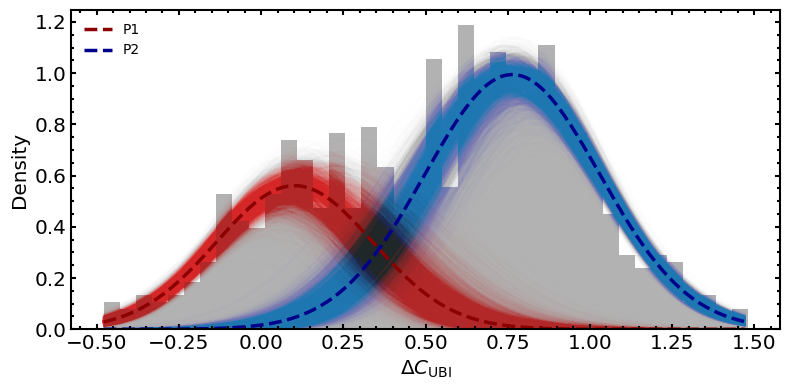

In [14]:
plot_twocomp_comparison(
    data, "$\\Delta C_\\mathrm{UBI}$",
    posteriors_new["loc_0"], posteriors_new["scale_1"], posteriors_new["weight_1"],
    posteriors_new["loc_0"] + posteriors_new["gap_0"], posteriors_new["scale_2"], posteriors_new["weight_2"],
    0.2
)
plt.tight_layout()
plt.savefig("model_new-data_ordered.png", dpi=600)

# Population Membership Probability

To reproduce the calculations from the paper, we need to assign population membership probabilities to each of the stars in the data set. We recover the "assignment variable" by using the "Predictive"

In [35]:
predictive = Predictive(
        model=model_univariate_ordered, 
        posterior_samples=mcmc_order.get_samples(), infer_discrete=True
)

discrete_samples = predictive(
        random.PRNGKey(0), 
        data, data_err, 2, (0.5, 3.0), 3.0
)

# Probabilities
p1 = jnp.array([
    np.where(discrete_samples["Assignment"][:, idx] == 0)[0].shape[0] / discrete_samples["Assignment"].shape[0]
    for idx in range(discrete_samples["Assignment"].shape[1])
])
    
p2 = jnp.array([
    np.where(discrete_samples["Assignment"][:, idx] == 1)[0].shape[0] / discrete_samples["Assignment"].shape[0]
    for idx in range(discrete_samples["Assignment"].shape[1])
])

We can make a short sanity check for this: If we plot the V-Band magnitude against the colour index, we should be able to see the probability gradient from left to right

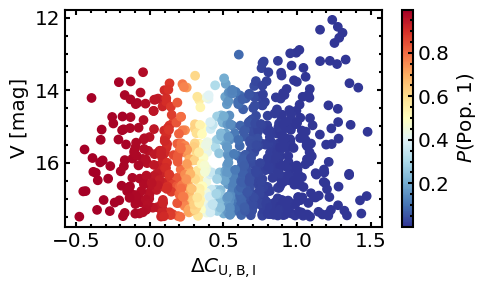

In [41]:
fig, ax = plt.subplots(figsize=(5, 3))
pops = ax.scatter(new_data["dCUBI"], new_data["V"], cmap="RdYlBu_r", c=p1)
ax.invert_yaxis()
ax.set(xlabel="$\\Delta C_\\mathrm{U,B,I}$", ylabel="V [mag]")
fig.colorbar(pops, label="$P$(Pop. 1)")
fig.tight_layout()

Then we save these probabilities together with the results to redo the kinematics analysis.

In [42]:
results = new_data.copy()
results["p_p1"] = p1
results["p_p2"] = p2
results.to_csv("univariate_newdata_results.csv", index=False)